In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from sklearn import impute
from sklearn import metrics
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn import kernel_approximation
from sklearn import ensemble

# from pyod.models import ecod, auto_encoder, xgbod

from catboost import CatBoostClassifier, Pool

import optuna
from hyperopt import hp, fmin, tpe, Trials, space_eval

# from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [3]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(
    palm_file, 
    n_omg_channels=50,
    n_acc_channels=3, 
    n_gyr_channels=3, 
    n_enc_channels=6, 
    n_mag_channels=0
)

print(gestures.shape)
gestures.head()

(19568, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909


In [4]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [5]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


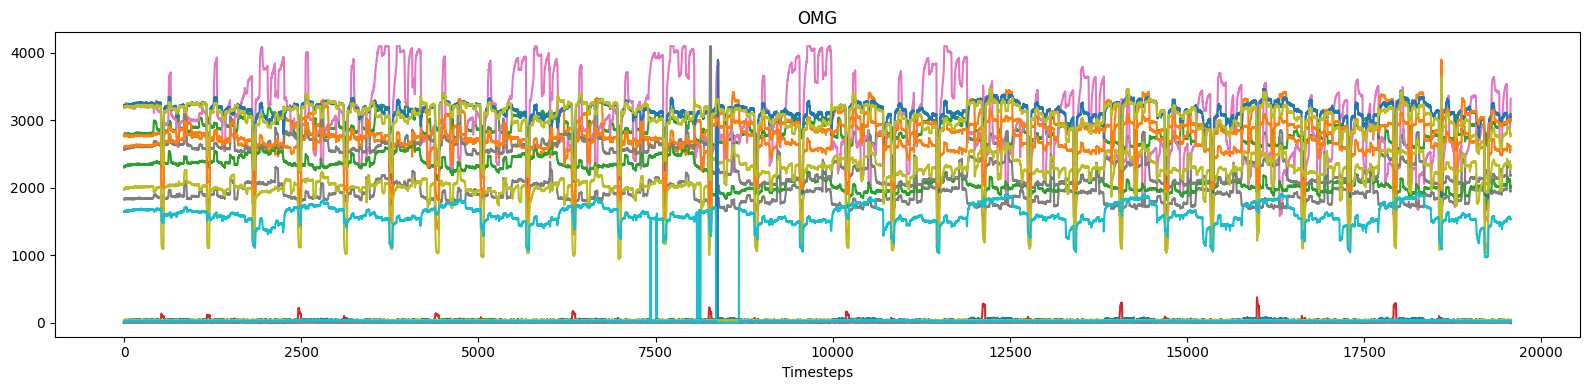

In [6]:
fig = plt.figure(figsize=(16, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

In [7]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
print('Shape of data:', gestures_protocol.shape)
gestures_protocol.head()

Shape of data: (181, 11)


,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [8]:
gestures['SYNC'].value_counts()

0      11266
57        58
67        58
97        47
135       47
       ...  
52        46
1         45
103       45
104       45
12        39
Name: SYNC, Length: 181, dtype: int64

In [9]:
le = preprocessing.LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [10]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [11]:
gestures_protocol['gesture'][:10]

epoch
0    0
1    0
2    3
3    5
4    1
5    4
6    2
7    0
8    3
9    5
Name: gesture, dtype: int32

In [12]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

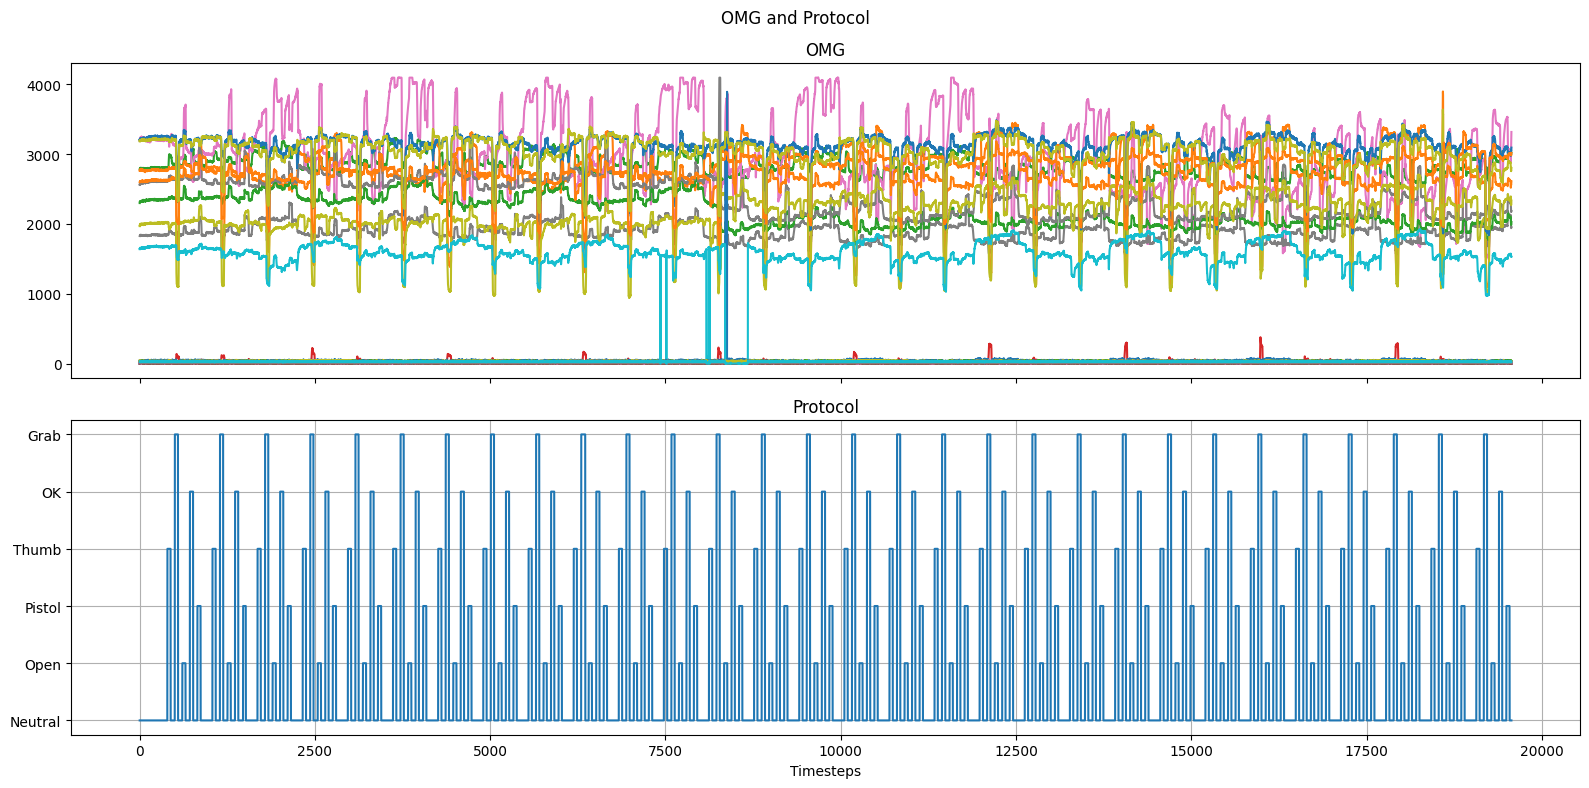

In [13]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Train-test split

In [14]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441
5,2023-06-20_13-30-15.palm,1,17928,17928,4435
6,2023-06-20_12-34-17.palm,1,17758,17758,4444
7,2023-09-30_08-06-44.palm,2,5693,5693,5509
8,2023-09-29_11-03-50.palm,2,5694,5694,5511
9,2023-09-29_09-20-47.palm,2,5690,5690,5507


In [15]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

In [16]:
X_train = gestures[OMG_CH].values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = gestures[OMG_CH].values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 50) (15679,)
(3889, 50) (3889,)


In [17]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,12,8,5,6,2,4,5,7,14,8,...,42,26,14,11,2,2,10,12,44,28
1,13,8,4,5,3,0,5,4,9,10,...,35,23,14,8,3,1,10,14,32,27
2,12,5,9,5,0,0,6,5,10,9,...,38,33,14,9,2,0,19,14,41,27
3,10,7,6,4,1,0,4,6,7,8,...,37,20,14,10,3,0,12,11,32,27
4,12,6,6,7,3,2,6,7,9,12,...,39,21,14,11,3,1,14,12,42,30


In [18]:
pd.Series(y_train).value_counts()

0    10151
5     1118
3     1104
1     1104
4     1104
2     1098
dtype: int64

---

## Подсчет длин рядов классов в векторе таргета

In [19]:
def count_adjacent_classes(vector):
    adj_classes = {}
    current_class = vector[0]
    count = 1
    class_count = {}

    for i in range(1, len(vector)):
        if vector[i] == current_class:
            count += 1
        else:
            key = f"{current_class}({class_count.get(current_class, 0)})"
            if count > 1:
                key = f"{current_class}({class_count.get(current_class, 0)})"
            adj_classes[key] = count
            class_count[current_class] = class_count.get(current_class, 0) + 1
            current_class = vector[i]
            count = 1

    key = f"{current_class}({class_count.get(current_class, 0)})"
    if count > 1:
        key = f"{current_class}({class_count.get(current_class, 0)})"
    adj_classes[key] = count
    class_count[current_class] = class_count.get(current_class, 0) + 1

    return adj_classes

# Пример использования
vector = np.array([1, 1, 2, 2, 2, 3, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1])
count_adjacent_classes(vector)

{'1(0)': 2, '2(0)': 3, '3(0)': 1, '1(1)': 3, '2(1)': 4, '3(1)': 6, '1(2)': 1}

In [20]:
print(count_adjacent_classes(y_train[:2000]))

{'0(0)': 395, '3(0)': 46, '0(1)': 60, '5(0)': 46, '0(2)': 61, '1(0)': 46, '0(3)': 62, '4(0)': 46, '0(4)': 61, '2(0)': 46, '0(5)': 169, '3(1)': 46, '0(6)': 61, '5(1)': 46, '0(7)': 62, '1(1)': 46, '0(8)': 61, '4(1)': 46, '0(9)': 69, '2(1)': 39, '0(10)': 167, '3(2)': 46, '0(11)': 61, '5(2)': 47, '0(12)': 61, '1(2)': 46, '0(13)': 58}


Как видим, в начале датасета у нас имеется довольно продолжительный участок с нейтральным таргетом. А также "окна" между сериями жестов длительностью чуть более 150 мс. И между жестами нейтральные интервалы длительностью 60 и чуть более мс.

В дальнейшем это знание нам пригодится.

---

## Оценка доли нулей

In [21]:
null_detect = gestures[[*OMG_CH, *ACC_CH, *GYR_CH, *ENC_CH]].replace(0, np.nan)

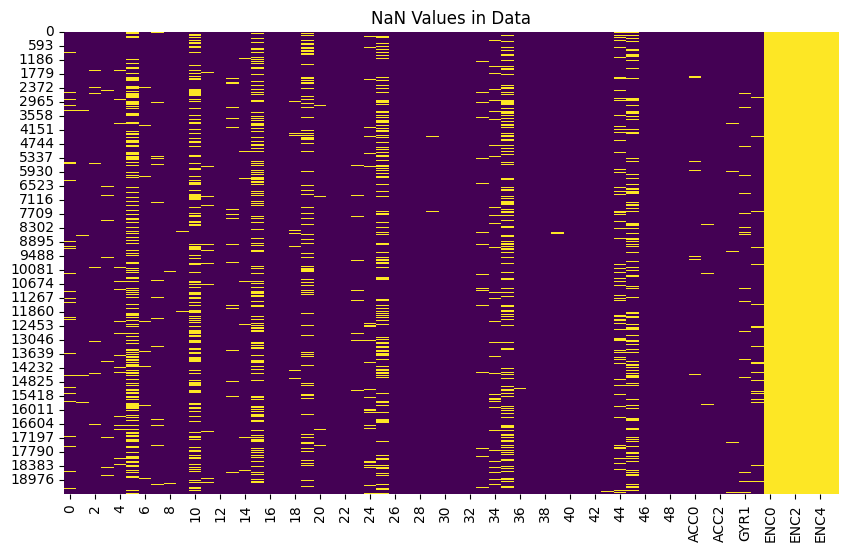

In [22]:
# Создайте тепловую карту для визуализации NaN-значений
plt.figure(figsize=(10, 6))
sns.heatmap(null_detect.isna(), cbar=False, cmap='viridis')
plt.title('NaN Values in Data')
plt.show()

In [23]:
cols_null_persent = null_detect.isna().mean() * 100
cols_with_null = cols_null_persent[cols_null_persent>0].sort_values(ascending=False)
cols_with_null[:10]

ENC5    100.000000
ENC4    100.000000
ENC3    100.000000
ENC2    100.000000
ENC1    100.000000
ENC0    100.000000
5        32.128986
10       31.720155
45       27.897588
15       27.187244
dtype: float64

---
---
---
---
---

# Preprocessing

In [24]:
# Функция для отрисовки графики "OMG and Protocol" для заданного интервала
def get_graphs(X_array, y_array, start=1000, end=1500):
    
    _, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    plt.grid(axis='x')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

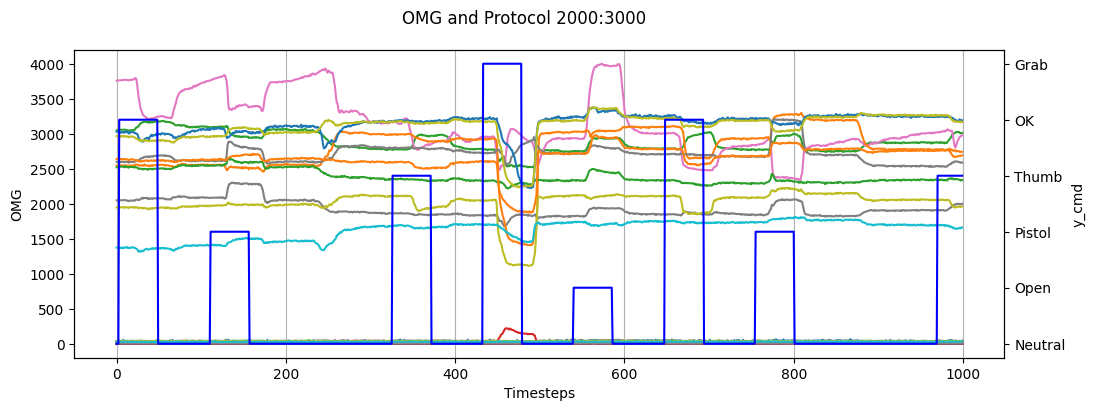

In [25]:
get_graphs(X_train, y_train, start=2000, end=3000)

## Устранение лага между сигналами датчиков и таргетом

In [26]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=20, model=svm.SVC()):
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    
    def get_score(X, y, model=model):
        model = model
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    # Раскомментив флаги можно вкл функционал ранней остановки
    # flag1, flag2 = True, True
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        current_score1 = get_score(X_part1, y_a)
        current_score2 = get_score(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        # else:
        #     flag1 = False
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
        # else:
        #     flag2 = False
        
        # if all([flag1, flag2]) == False:
        #     break
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Точность модели на концевых выборках:      {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

Сдвинем таргет в обеих выборках вдоль всех данных на оптимальный шаг.

In [27]:
fitting_model = svm.LinearSVC(dual='auto')
y_train_shifted, summary = get_naive_centering(X_train, y_train, inter=500, window=30, model=fitting_model)
print('Train sample shifting\n', *summary, '\n', sep='')
y_test_shifted, summary = get_naive_centering(X_test, y_test, inter=500, window=30, model=fitting_model)
print('Test sample shifting\n', *summary, sep='')

Train sample shifting
Оптимальные свдиги для концевых выборок:   17 и 18
Точность модели на концевых выборках:      0.998; 1.0
Размер оптимального сдвига (как среднего): 18



Test sample shifting
Оптимальные свдиги для концевых выборок:   21 и 21
Точность модели на концевых выборках:      0.998; 0.998
Размер оптимального сдвига (как среднего): 21


Посмотрим на результат.

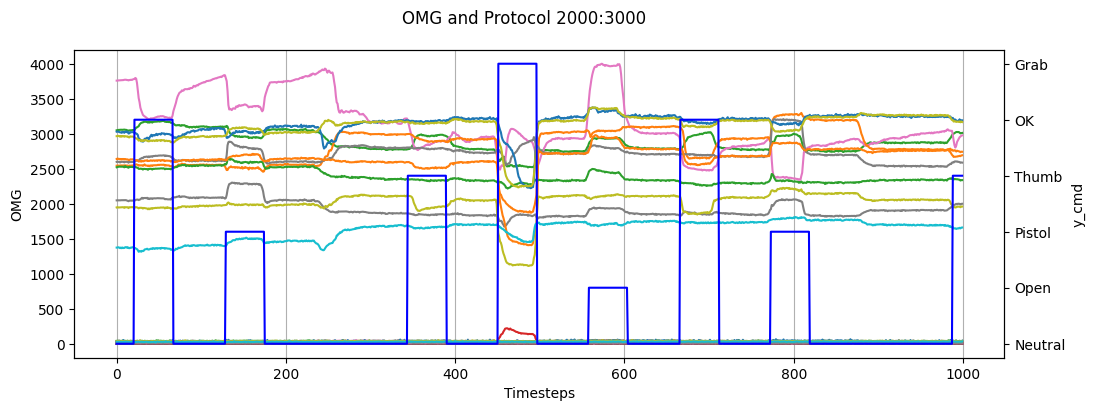

In [28]:
get_graphs(X_train, y_train_shifted, start=2000, end=3000)

## Дифференцирование сигналов

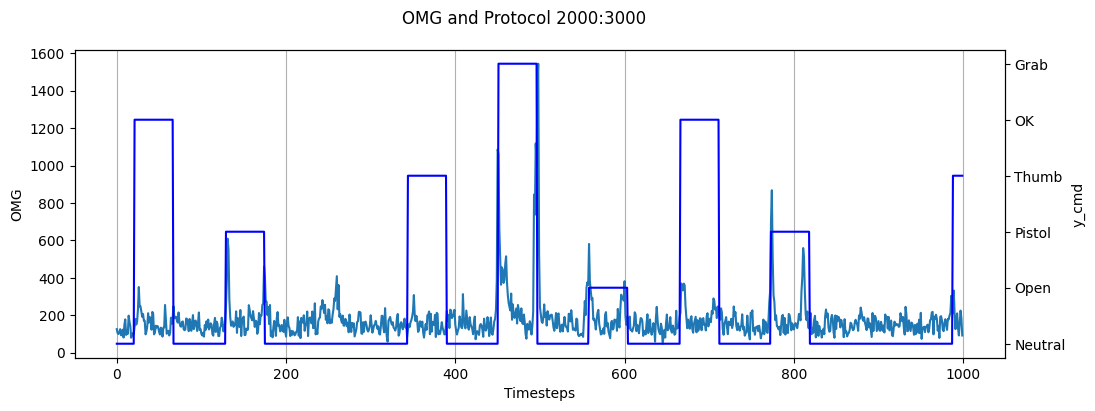

In [29]:
X_train_diff = pd.DataFrame(X_train).diff().abs().sum(axis=1)

get_graphs(X_train_diff.values, y_train_shifted, start=2000, end=3000)

## y_Thumb

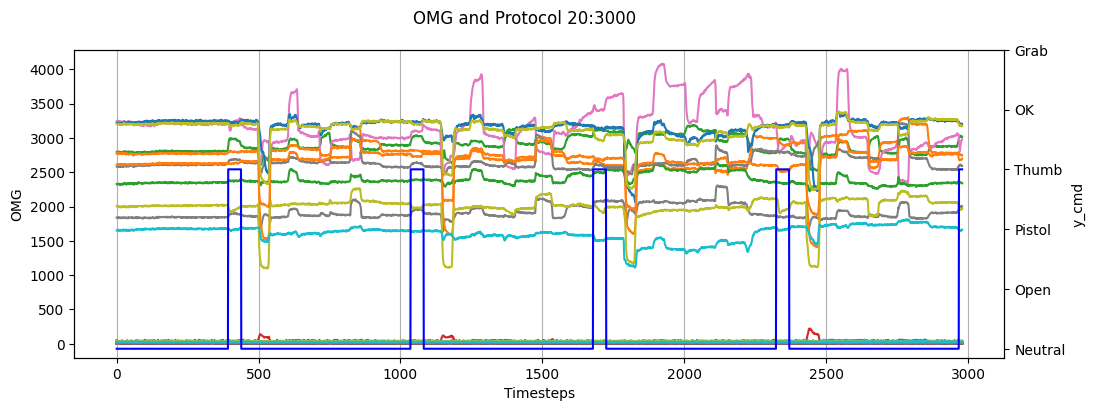

In [73]:
y_train_Thumb = np.where(y_train_shifted == 3, y_train_shifted, 0)
y_test_Thumb = np.where(y_test_shifted == 3, y_test_shifted, 0)

get_graphs(X_train, y_train_Thumb, start=20, end=3000)

## Генерация признаков

In [30]:
# from tsfresh import extract_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import settings

In [31]:
# settings_comprehensive = settings.ComprehensiveFCParameters()

# X_long = pd.DataFrame({
#     0: gestures[OMG_CH].values.flatten(),
#     1: np.arange(gestures[OMG_CH].shape[0]).repeat(gestures[OMG_CH].shape[1])
# })

# X_extract = extract_features(X_long, column_id=1, impute_function=impute, default_fc_parameters=settings_comprehensive)

# X_train = X_extract.values[:last_train_idx]
# X_test = X_extract.values[last_train_idx:]

## Экспоненциальное сглаживаение

In [32]:
# Функция для экспоненциального сглаживания
def get_smoothing(Xdf, sample_size=5, alpha=0.3):
    samples, j = [], 0
    for i in range(sample_size, Xdf.shape[0] + 1, sample_size):
        x_smoothed = Xdf.loc[j:i-1, list(Xdf.columns)].ewm(alpha=alpha, adjust=True).mean().values
        samples.append(x_smoothed)
        j = i
    
    X_ewm = np.row_stack(samples)
    
    return X_ewm

X_train_ewm = get_smoothing(pd.DataFrame(X_train))
X_test_ewm = get_smoothing(pd.DataFrame(X_test))

In [33]:
print(X_train_ewm.shape, y_train_shifted.shape)
print(X_test_ewm.shape, y_test_shifted.shape)

(15675, 50) (15679,)
(3885, 50) (3889,)


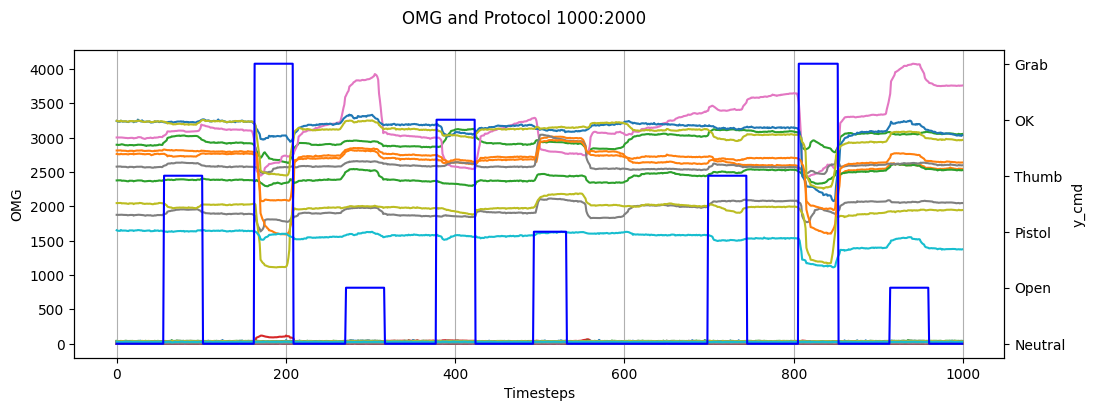

In [34]:
get_graphs(X_train_ewm, y_train_shifted, start=1000, end=2000)

## Корреляционный анализ

In [35]:
def high_correlation_lower_triangle(data, threshold=0.9):
    corr_matrix = pd.DataFrame(data).corr().abs()
    mask = np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)
    lower_triangle_corr = corr_matrix.where(mask)

    high_corr = (lower_triangle_corr > threshold) & (lower_triangle_corr < 1.0)
    correlated_vars = []

    for column in high_corr.columns:
        correlated = list(high_corr.index[high_corr[column]])
        for var in correlated:
            if high_corr.loc[var, column]:
                correlated_vars.append((column, var))

    return correlated_vars

print('For train sample:')
print(high_correlation_lower_triangle(X_train_ewm), '\n')
print('For test sample:')
print(high_correlation_lower_triangle(X_test_ewm))

For train sample:
[(28, 31)] 

For test sample:
[(21, 28)]


Выберем и удалим высокоскореллированные признаки.

In [36]:
X_train_cd = pd.DataFrame(X_train_ewm).drop([28], axis=1)
X_test_cd = pd.DataFrame(X_test_ewm).drop([28], axis=1)
high_correlation_lower_triangle(X_train_cd)

[]

## Стандартизация

In [37]:
from sklearn import preprocessing

std_scaler = preprocessing.StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train_cd)
X_test_scaled = std_scaler.transform(X_test_cd)

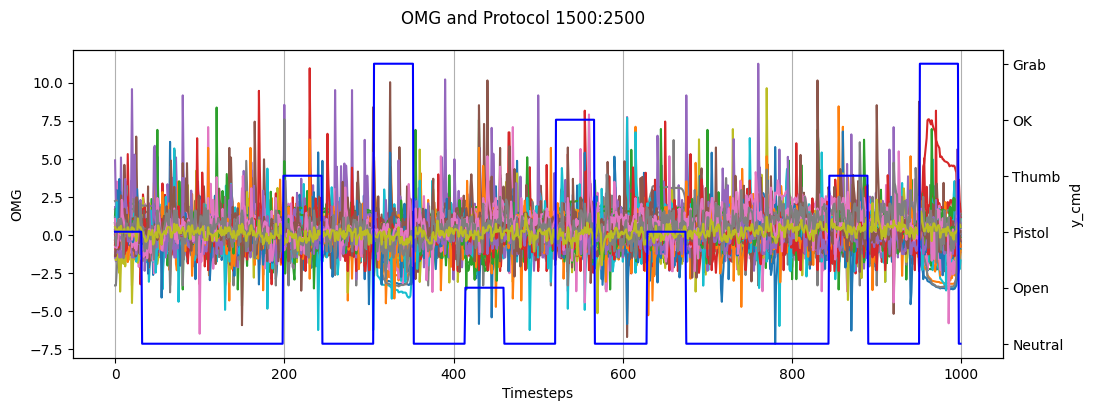

In [38]:
get_graphs(X_train_scaled, y_train_shifted, start=1500, end=2500)

## Устранение мультиколлинеарности

In [39]:
# Матрица корреляций
corr_mtrx = pd.DataFrame(data=X_train_scaled).corr()

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 49
Ранг матрицы:   49
Определитель:   1.5051554312232946e-11


In [40]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,99 % разброса данных
pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_scaled)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 49


In [41]:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_train_pca.transpose())

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 49
Ранг матрицы:   49
Определитель:   0.9999999999999987


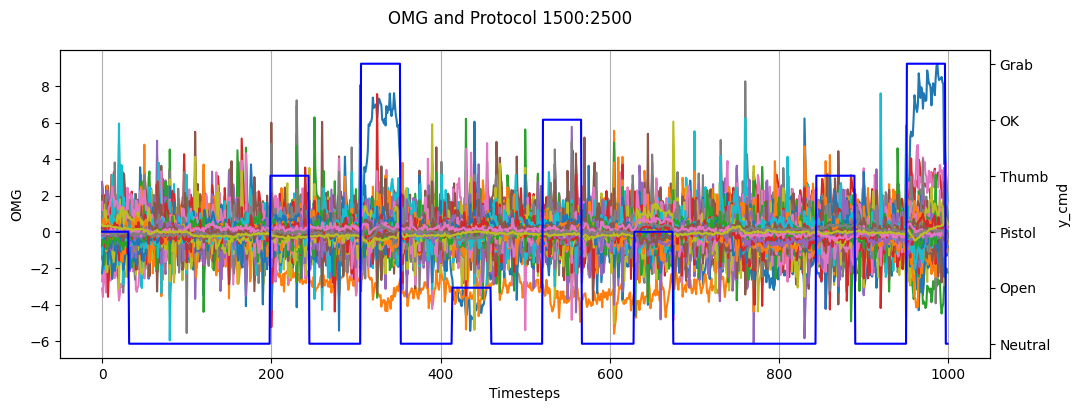

In [42]:
get_graphs(X_train_pca, y_train_shifted, start=1500, end=2500)

omg...

## Контроль размеров

In [43]:
print(X_train_pca.shape, y_train_shifted.shape)
print(X_test_pca.shape, y_test_shifted.shape)

(15675, 49) (15679,)
(3885, 49) (3889,)


Выборки могли стать чут короче из-за сглаживания. Приведем размер их таргетов в соответствие.

In [44]:
y_train_shifted_ = y_train_shifted[:X_train_pca.shape[0]]
y_test_shifted_ = y_test_shifted[:X_test_pca.shape[0]]

print(X_train_pca.shape, y_train_shifted_.shape)
print(X_test_pca.shape, y_test_shifted_.shape)

(15675, 49) (15675,)
(3885, 49) (3885,)


In [76]:
y_train_Thumb_shifted_ = y_train_Thumb[:X_train_pca.shape[0]]
y_test_Thumb_shifted_ = y_test_Thumb[:X_test_pca.shape[0]]

# Modeling

### Взвешивание классов

In [45]:
# from sklearn.utils import class_weight

# classes = np.unique(y_train)
# weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# class_weights = dict(zip(classes, weights))

---

### CatBoostClassifier

In [46]:
%%time
model = CatBoostClassifier(
    verbose=False,
    random_seed=42
)

model.fit(X_train_pca, y_train_shifted_)

CPU times: total: 3min 22s
Wall time: 20 s


---

### LogisticRegression

In [80]:
# %%time
# lr_Thumb = linear_model.LogisticRegression(
#     solver='newton-cg',
#     random_state=42,
#     max_iter=1000,
#     n_jobs=-1
# )

# lr_Thumb.fit(X_train_pca, y_train_Thumb_shifted_)

CPU times: total: 0 ns
Wall time: 592 ms


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42,
                   solver='newton-cg')

In [85]:
# train_Thumb_preds = lr_Thumb.predict(X_train_pca)
# test_Thumb_preds = lr_Thumb.predict(X_test_pca)

# print('Train preds metrics report:')
# print(metrics.classification_report(
#     y_train_Thumb_shifted_, train_Thumb_preds, digits=4))
# print('-'*55)
# print('Test preds metrics report:')
# print(metrics.classification_report(
#     y_test_Thumb_shifted_, test_Thumb_preds, digits=4))

Train preds metrics report:
              precision    recall  f1-score   support

           0     0.9792    0.9914    0.9853     14571
           3     0.8644    0.7219    0.7868      1104

    accuracy                         0.9724     15675
   macro avg     0.9218    0.8567    0.8860     15675
weighted avg     0.9711    0.9724    0.9713     15675

-------------------------------------------------------
Test preds metrics report:
              precision    recall  f1-score   support

           0     0.9539    0.9856    0.9695      3609
           3     0.6667    0.3768    0.4815       276

    accuracy                         0.9423      3885
   macro avg     0.8103    0.6812    0.7255      3885
weighted avg     0.9335    0.9423    0.9348      3885



In [90]:
%%time
model = linear_model.LogisticRegression(
    solver='newton-cg',
    random_state=42,
    max_iter=1000,
    n_jobs=-1
)

model.fit(X_train_pca, y_train_shifted_)

CPU times: total: 0 ns
Wall time: 1.41 s


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42,
                   solver='newton-cg')

In [79]:
# %%time
# # Напишем функцию для оптимизации
# def optuna_LogR(trial):
#     """Функция, обучающая модель LogisticRegression по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'penalty': trial.suggest_categorical('penalty', ['l2', None]),
#         'C': trial.suggest_float('C', 0.1, 1),
#         'solver': trial.suggest_categorical('solver', ['newton-cg', 'newton-cholesky']),
#         'max_iter': trial.suggest_categorical('max_iter', [3000])
#     }
    
#     # Создаем модель
#     model = linear_model.LogisticRegression(
#         **params,
#         random_state=42,
#         n_jobs=-1
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         model, X_train_pca, y_train_shifted_, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()
#     return score

# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_LogR = optuna.create_study(study_name="LogR_opt", direction="maximize",)
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Ищем лучшую комбинацию гиперпараметров n_trials раз
# study_LogR.optimize(optuna_LogR, n_trials=50)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.LogisticRegression(
#     **study_LogR.best_params,
#     random_state=42,
#     n_jobs=-1
# )
# # Обучение
# model.fit(X_train_pca, y_train_shifted_)

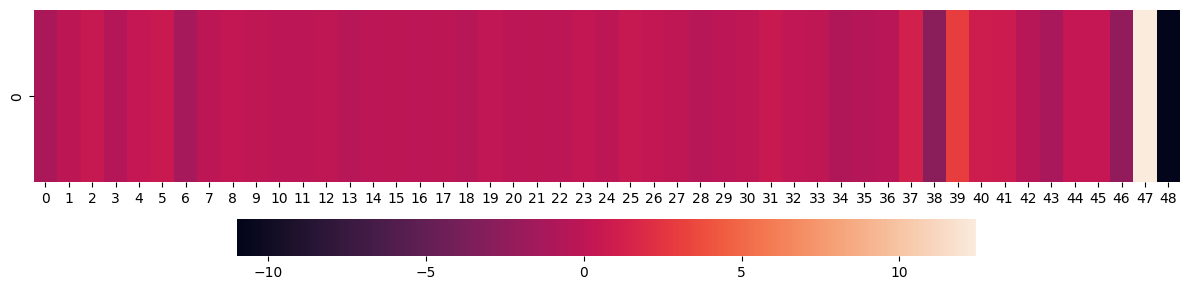

In [78]:
plt.figure(figsize=(12, 3)) # 
sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
plt.tight_layout()

---

### SVC

In [95]:
%%time
# Инициализация объекта
model = svm.SVC(
    kernel='rbf',
    random_state=42
)

# Обучение
model.fit(X_train_pca, y_train_shifted_)

CPU times: total: 2.94 s
Wall time: 2.97 s


SVC(random_state=42)

## Prediction

preds of SVC

In [96]:
%%time
y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)

CPU times: total: 7.2 s
Wall time: 7.21 s


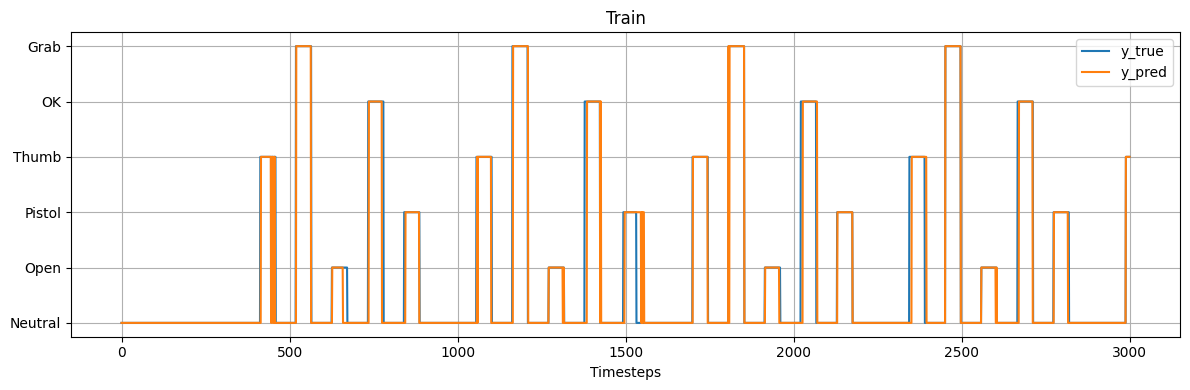

In [97]:
fig = plt.figure(figsize=(12, 4))
plt.plot(y_train_shifted_[:3000],  c='C0', label='y_true')
plt.plot(y_pred_train[:3000], c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

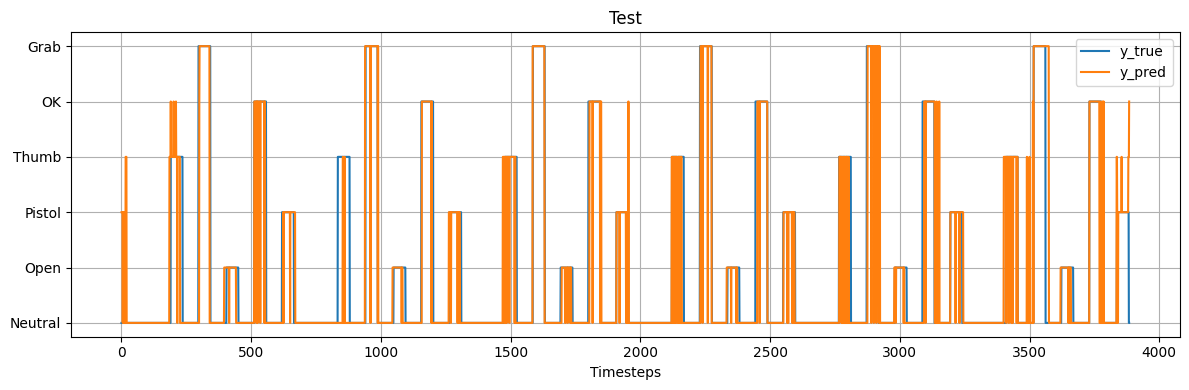

In [98]:
fig = plt.figure(figsize=(12, 4))
plt.plot(y_test_shifted_, c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [99]:
print('Train preds metrics report:')
print(metrics.classification_report(
    y_train_shifted_, y_pred_train, target_names=GESTURES, digits=4))
print('-'*55)
print('Test preds metrics report:')
print(metrics.classification_report(
    y_test_shifted_, y_pred_test, target_names=GESTURES, digits=4))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_test_shifted_, y_pred_test)
# определяем название активностей
ct.index = ct.columns = GESTURES
ct

Train preds metrics report:
              precision    recall  f1-score   support

     Neutral     0.9568    0.9877    0.9720     10169
        Open     0.9949    0.8913    0.9403      1104
      Pistol     0.9664    0.9099    0.9373      1076
       Thumb     0.9683    0.9411    0.9545      1104
          OK     0.9666    0.8904    0.9269      1104
        Grab     0.9797    0.9517    0.9655      1118

    accuracy                         0.9629     15675
   macro avg     0.9721    0.9287    0.9494     15675
weighted avg     0.9633    0.9629    0.9625     15675

-------------------------------------------------------
Test preds metrics report:
              precision    recall  f1-score   support

     Neutral     0.8953    0.9565    0.9249      2504
        Open     0.9083    0.7536    0.8238       276
      Pistol     0.9091    0.8696    0.8889       276
       Thumb     0.8245    0.5616    0.6681       276
          OK     0.9283    0.8442    0.8843       276
        Grab     0.92

,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,2395,21,24,29,14,21
Open,68,208,0,0,0,0
Pistol,32,0,240,4,0,0
Thumb,118,0,0,155,3,0
OK,43,0,0,0,233,0
Grab,19,0,0,0,1,257


In [55]:
def cv_metrics(X_arr, y_arr, model):
    
    cv_metrics = model_selection.cross_validate(
        estimator=model, #модель
        X=X_arr, #матрица наблюдений X
        y=y_arr, #вектор ответов y
        scoring='f1_weighted', #метрика
        cv=5,
        return_train_score=True #подсчёт метрики на тренировочных фолдах
    )
    
    print('Train k-fold mean f1_weighted: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
    print('Valid k-fold mean f1_weighted: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

In [56]:
%%time
cv_metrics(X_train_pca, y_train_shifted_, model)

Train k-fold mean f1_weighted: 0.96
Valid k-fold mean f1_weighted: 0.88
CPU times: total: 34.6 s
Wall time: 34.6 s


---
---
---
---
---

# Real-time inference

In [57]:
import time
from serial import Serial
from IPython.display import clear_output

In [58]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [59]:
def preprocessing(x, prev):
    # x - sample vector
    x_cd = pd.DataFrame(x.reshape(1, -1)).drop([28], axis=1)
    x_scaled = std_scaler.transform(x_cd)
    x_pca = pca.transform(x_scaled)
    if prev is None:
        prev = x_pca
        y = x_pca.reshape(1, -1)
    else:
        prev = np.vstack((prev, x_pca))
        if prev.shape[0] < 6:
            y = get_smoothing(pd.DataFrame(prev), sample_size=prev.shape[0], alpha=0.2)[-1]
        else:
            prev = prev[1:]
            y = get_smoothing(pd.DataFrame(prev), sample_size=prev.shape[0], alpha=0.2)[-1]
    return y.reshape(1, -1), prev


def inference(x):
    y = model.predict(x)
    return y


def postprocessing(x, prev):
    if prev is None:
        prev = x
        y = x
    else:
        if prev.shape[0] < 6:
            prev = np.vstack((prev, x))
            # Подсчитываем количество вхождений каждого элемента
            counts = np.bincount(prev.reshape(-1,))
            # Находим индекс элемента с максимальным количеством вхождений
            y = np.argmax(counts)
        else:
            prev = np.vstack((prev, x))[1:]
            counts = np.bincount(prev.reshape(-1,))
            y = np.argmax(counts)
    return y.reshape(1,), prev


def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y.reshape(1,)

## Inference

### Offline (dataset)

In [60]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [61]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

ts_diffs = []
x_previous = None
y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed, x_previous = preprocessing(omg_sample, x_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    # y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    ts_diffs.append(ts_diff)
    i += 1 

In [62]:
np.mean(ts_diffs)

0.0023359006031769105

In [63]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 1, 49)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


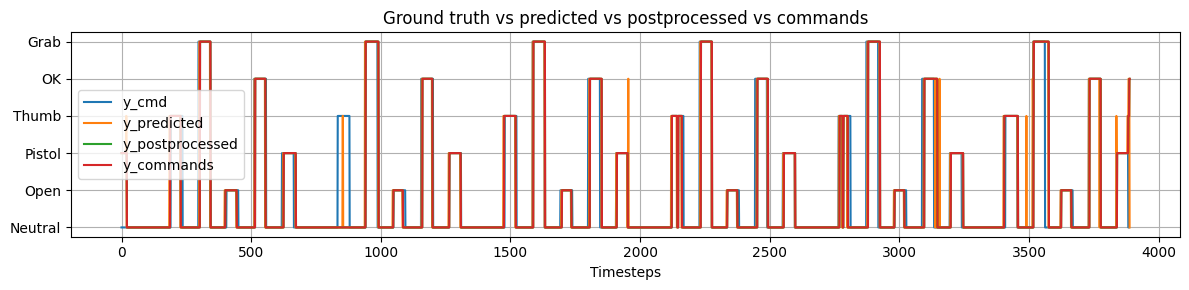

In [64]:
fig = plt.figure(figsize=(12, 3))

plt.plot(y_test_shifted_, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [65]:
print(metrics.classification_report(
    y_test_shifted, y_dct['y_commands'], target_names=GESTURES, digits=4
))

              precision    recall  f1-score   support

     Neutral     0.9162    0.9549    0.9352      2508
        Open     0.9829    0.8333    0.9020       276
      Pistol     0.8720    0.9130    0.8920       276
       Thumb     0.9275    0.6957    0.7950       276
          OK     0.8969    0.8514    0.8736       276
        Grab     0.8905    0.9097    0.9000       277

    accuracy                         0.9144      3889
   macro avg     0.9143    0.8597    0.8830      3889
weighted avg     0.9154    0.9144    0.9129      3889



In [66]:
# создаём таблицу сопряжённости
ct = pd.crosstab(y_test_shifted, y_dct['y_commands'].reshape(-1,))
# определяем название активностей
ct.index = ct.columns = GESTURES
ct

,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,2395,4,37,15,26,31
Open,46,230,0,0,0,0
Pistol,24,0,252,0,0,0
Thumb,84,0,0,192,0,0
OK,41,0,0,0,235,0
Grab,24,0,0,0,1,252


### Online (prosthesis or virtual hand)

In [67]:
# TIMEOUT = 0.033
# DEBUG = True

# ser = None
# ser_port = None
# # ser_port = '/dev/ttyACM0'
# # ser_port = '/dev/cu.usbmodem3498365F31351'

# if ser_port is not None:
#     ser = Serial(port=ser_port, timeout=2*TIMEOUT)
#     ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
#     ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
#     ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

#     # flush buffers
#     ser.reset_input_buffer()
#     ser.read()
    
#     i = 0;
#     while(ser.in_waiting):
#         print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
#         ser.read_all()
#         time.sleep(0.005)
#         i+=1;
#     ser.readline()
#     ser.readline()
    
# i = 0
# ts_old = time.time()
# ts_diff = 0;

# y_previous = None
# while True:    
    
#     # [Data reading]
#     s = ser.readline()
#     ts_start = time.time()
    
#     try:
#         sample = np.array(s.decode('UTF-8')\
#                            .replace('\r\n', "")\
#                            .split(' ')
#                          ).astype(int)
#         [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
#     except Exception as e:
#         print(e)
        
#     # [/Data Reading]
        
#     # [Data preprocessing]
#     sample_preprocessed = preprocessing(omg_sample)
#     # [/Data preprocessing]
    
#     # [Inference]
#     y_predicted         = inference(sample_preprocessed)
#     # [/Inference]
    
#     # [Inference Postprocessing]
#     y_postprocessed     = postprocessing(y_predicted, y_previous)
#     # [/Inference Postprocessing]
    
#     # [Commands composition]
#     y_commands          = commands(y_postprocessed)
#     # [/Commands composition]
    
#     # [Commands sending]
#     pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
#     # [/Commands sending]
    
#     y_previous = y_postprocessed
    
#     if DEBUG:
#         clear_output(wait=True)

#         # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
#         print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
#         print('INPUT:\n', s)

#         # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
#         print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
#         print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
#         print(y_commands)
#         print(pack)
    
#     ts_diff = time.time() - ts_start
#     assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
#     ts_old = ts_start
#     i += 1 

---